In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [499]:
cutoff_date = '2022-12-31' ## len = 65
test_period = 12 ## 예측 기간 (월)
corr_rate = 0.5 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 30
hist_variable_limit = 30

## <원 data set>

In [505]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [ ]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

#### 해당 기간에서의 lag corr best

In [ ]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_y['y'] = abs(raw_y_set_shifted_merged_filtered_y['y'])
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]
# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [ ]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

In [ ]:
futr_list

#### 해당 기간에서의 corr best

In [ ]:
hist_variable_limit

In [ ]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

In [ ]:
hist_var_corr_filtered_y_only

#### static DF

In [ ]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [ ]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [ ]:
# len(df.loc[df.ds<'2021-06-30'])

In [ ]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [ ]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [232]:
futr_list

['HOUSECOST_FIN',
 '1772.HK(Ganfeng Lithium)_Price_Low',
 '1772.HK(Ganfeng Lithium)_Price_Open',
 '1772.HK(Ganfeng Lithium)_Price_Close',
 '1772.HK(Ganfeng Lithium)_Price_Adj Close',
 '1772.HK(Ganfeng Lithium)_Price_High',
 'Cameco(CCJ)_Adj Close',
 'Cameco(CCJ)_High',
 'Cameco(CCJ)_Open',
 'Cameco(CCJ)_Close',
 '보일러용 후판 Q345R 30mm Xinyu Steel [중국] 현물',
 'Cameco(CCJ)_Low',
 'PPP_RUS',
 'PPP_LVA',
 'HOUSECOST_NZL',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 'ALB_price_Adj Close',
 'ALB_price_High',
 'ALB_price_Close',
 'ALB_price_Open',
 'HOUSECOST_AUS',
 'ALB_price_Low',
 'LAC_price_Low',
 'Howe Robinson Container Index',
 'LAC_price_Open',
 'LAC_price_Close',
 'LAC_price_Adj Close',
 'LAC_price_High',
 'LGES 리튬소요량_수산화리튬(kg)',
 'PPP_LTU']

In [233]:
# futr_list = ['HOUSECOST_FIN',
#  '1772.HK(Ganfeng Lithium)_Price_Low',
#  '1772.HK(Ganfeng Lithium)_Price_Open',
#  '1772.HK(Ganfeng Lithium)_Price_Close',
#  '1772.HK(Ganfeng Lithium)_Price_Adj Close',
#  '1772.HK(Ganfeng Lithium)_Price_High',
#  'Cameco(CCJ)_Adj Close',
#  'Cameco(CCJ)_High',
#  'Cameco(CCJ)_Open',
#  'Cameco(CCJ)_Close']

In [234]:
# futr_list = [
#              'Baltic Dry Index (BDI)',
#              'Howe Robinson Container Index',
#              'Shanghai Containerized Freight Index (SCFI)',
#              # 'lioh_mag_am_kg',
#              # 'LGES 리튬소요량_수산화리튬(kg)',
#              # '옥수수 For Grain [미국(생산자 가격)] 현물',
#              # '대두 [미국(생산자 가격)] 현물',
#              # '대두박 [파라나구아(FOB)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              # 'LGES 리튬소요량_탄산리튬(kg)',
#              # 'Pilbara Mineral Limited price Open',
#              # 'li2co3_cif_fast_kg_spot_exchng'
#              # '미국 비농업부분고용',
#             ]

In [235]:
futr_list

['HOUSECOST_FIN',
 '1772.HK(Ganfeng Lithium)_Price_Low',
 '1772.HK(Ganfeng Lithium)_Price_Open',
 '1772.HK(Ganfeng Lithium)_Price_Close',
 '1772.HK(Ganfeng Lithium)_Price_Adj Close',
 '1772.HK(Ganfeng Lithium)_Price_High',
 'Cameco(CCJ)_Adj Close',
 'Cameco(CCJ)_High',
 'Cameco(CCJ)_Open',
 'Cameco(CCJ)_Close',
 '보일러용 후판 Q345R 30mm Xinyu Steel [중국] 현물',
 'Cameco(CCJ)_Low',
 'PPP_RUS',
 'PPP_LVA',
 'HOUSECOST_NZL',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 'ALB_price_Adj Close',
 'ALB_price_High',
 'ALB_price_Close',
 'ALB_price_Open',
 'HOUSECOST_AUS',
 'ALB_price_Low',
 'LAC_price_Low',
 'Howe Robinson Container Index',
 'LAC_price_Open',
 'LAC_price_Close',
 'LAC_price_Adj Close',
 'LAC_price_High',
 'LGES 리튬소요량_수산화리튬(kg)',
 'PPP_LTU']

In [236]:
Y_test_df_list = list(Y_test_df)
Y_test_df_list = [x for x in Y_test_df_list if x not in futr_list]
Y_test_df_list[3:3] = futr_list
Y_test_df = Y_test_df[Y_test_df_list]

Y_train_df_list = list(Y_train_df)
Y_train_df_list = [x for x in Y_train_df if x not in futr_list]
Y_train_df_list[3:3] = futr_list
Y_train_df = Y_train_df[Y_train_df_list]

In [237]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,Howe Robinson Container Index,옥수수 For Grain [미국(생산자 가격)] 현물,LGES 리튬소요량_수산화리튬(kg),보일러용 후판 Q345R 30mm Xinyu Steel [중국] 현물,HOUSECOST_AUS,HOUSECOST_FIN,HOUSECOST_NZL,PPP_LTU,...,LAC_price_Open,LAC_price_High,LAC_price_Low,LAC_price_Close,LAC_price_Adj Close,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_High,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close
0,2023-01-31,A,1.983558,1.048823,0.935882,1.712108,-0.998466,0.744984,1.766310,1.477524,...,2.005109,1.995952,1.985077,1.982353,1.982353,1.586656,1.566521,1.591698,1.585566,1.583227
1,2023-02-28,A,2.294724,1.467862,0.897597,1.894103,-0.998466,0.744984,1.766310,1.477524,...,1.909121,1.923140,1.941953,1.940593,1.940593,1.728255,1.720887,1.749242,1.743348,1.740182
2,2023-03-31,A,2.612162,1.831557,1.163820,1.918363,-0.998466,0.744984,1.766310,1.477524,...,2.074784,2.127488,2.091311,2.126649,2.126649,1.407937,1.397419,1.389449,1.384712,1.383427
3,2023-04-30,A,2.556884,2.242691,1.212245,1.629483,-0.874747,0.716308,1.581444,1.477524,...,2.316314,2.291464,2.243617,2.228442,2.228442,1.141380,1.140003,1.132464,1.134450,1.134478
4,2023-05-31,A,2.501607,2.385006,1.083226,1.585083,-0.874747,0.716308,1.581444,1.477524,...,1.588567,1.604325,1.559607,1.584550,1.584550,1.063306,1.066957,1.087993,1.077455,1.077782
5,2023-06-30,A,2.515599,2.471976,1.078285,1.438440,-0.874747,0.716308,1.581444,1.477524,...,1.339654,1.323487,1.346522,1.331576,1.331576,1.394566,1.411001,1.423868,1.430067,1.439884
6,2023-07-31,A,2.439292,2.377100,1.903112,0.653879,-0.692016,3.046615,-0.198878,1.477524,...,1.279127,1.273195,1.305257,1.309183,1.309183,1.369106,1.347666,1.377769,1.352985,1.371378
7,2023-08-31,A,2.119559,2.369193,1.924302,0.335386,-0.692016,3.046615,-0.198878,1.477524,...,2.043213,2.028341,2.083094,2.062310,2.062310,1.179453,1.162265,1.206883,1.188562,1.206447
8,2023-09-30,A,1.188816,2.250597,2.173007,0.123829,-0.692016,3.046615,-0.198878,1.477524,...,2.028986,2.019256,2.057453,2.041390,2.041390,0.917671,0.901664,0.933301,0.907518,0.924534
9,2023-10-31,A,0.204375,1.784119,2.608211,-0.077163,2.605922,3.167846,1.999421,1.477524,...,1.630685,1.615169,1.641360,1.631476,1.631476,0.639685,0.634064,0.654932,0.640460,0.656652


#### No 변수

In [238]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [239]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [240]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [441]:
# futr_list = ['보일러용 후판 Q345R 30mm Xinyu Steel [중국] 현물']

In [447]:
if len(Y_test_df) >= 6:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_list

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=horizon, input_size=5 * horizon,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,
          #       # hist_exog_list = hist_list,
          #       # futr_exog_list = None,  
          #       futr_exog_list = flexible,
          #       learning_rate=1e-4,
          #       mlp_units = [[512, 512], [512, 512], [512, 512]],
          #       batch_size=128,
          #       random_seed=42,
          #       n_blocks=[1, 1, 1],
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #       max_steps=30
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                hist_exog_list = hist_list,
                futr_exog_list = flexible,
                # futr_exog_list = None,
                # futr_exog_list = futr_list,
                n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                n_freq_downsample=[24, 12, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=100
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='standard',
          #        learning_rate=1e-4,
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=flexible,
          #        hist_exog_list=None,
          #        stat_exog_list=None,
          #        max_steps=200
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     hidden_size=128,
          #     # n_head=4, 
          #     attn_dropout=0.2,
          #     # hist_exog_list=hist_list,
          #     dropout=0.6,
          #     learning_rate=1e-4,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     # enable_progress_bar=True,
          #     max_steps=200
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
# Y_hat_df = nforecast.predict(futr_df=futr_df)

Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

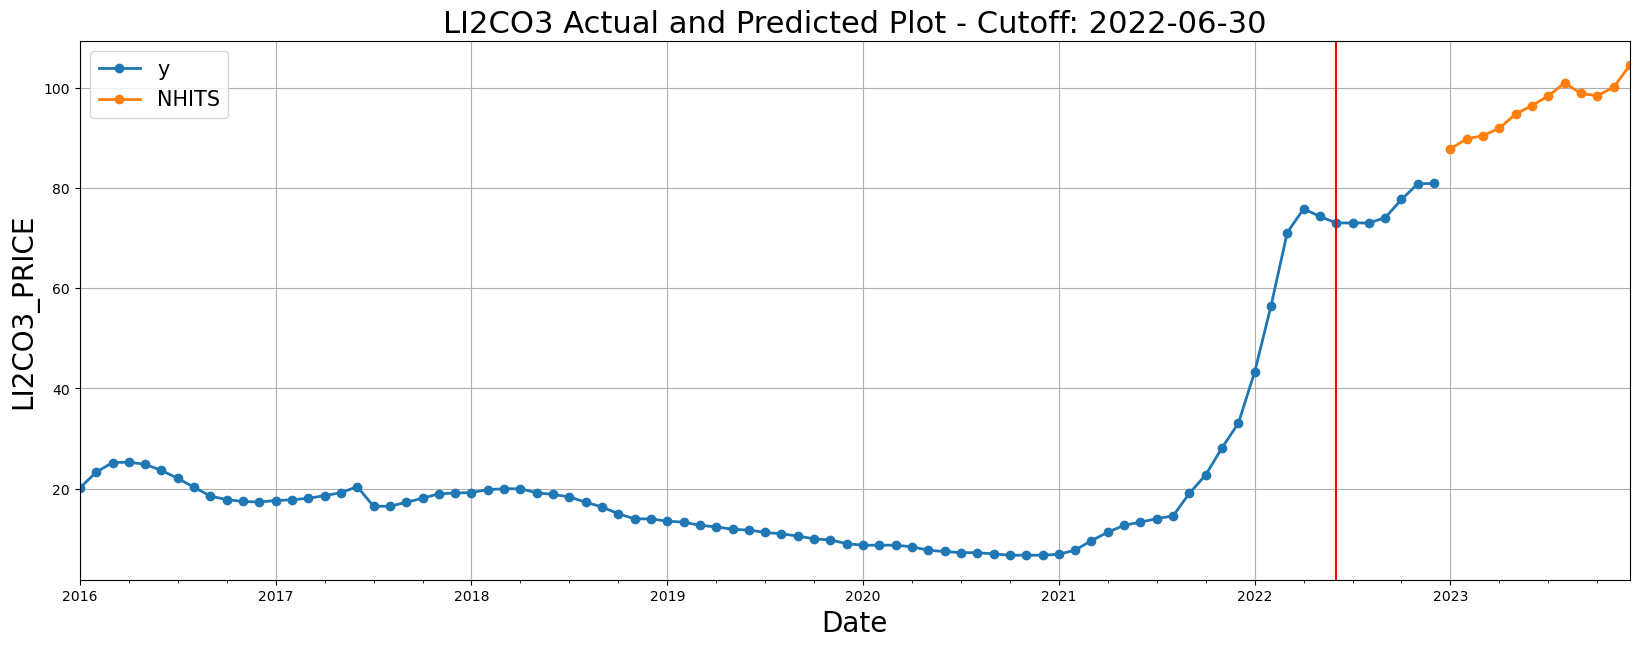

In [448]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

if len(Y_test_df) > 0:
    Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
else:
    plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [449]:
plot_df

,unique_id,y,HOUSECOST_FIN,1772.HK(Ganfeng Lithium)_Price_Low,1772.HK(Ganfeng Lithium)_Price_Open,1772.HK(Ganfeng Lithium)_Price_Close,1772.HK(Ganfeng Lithium)_Price_Adj Close,1772.HK(Ganfeng Lithium)_Price_High,Cameco(CCJ)_Adj Close,Cameco(CCJ)_High,...,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close,NHITS
ds,,,,,,,,,,,,,,,,,,,,,
2016-01-31,A,20.177268,-0.697250,-0.71162,-0.708309,-0.710711,-0.712605,-0.708782,-0.492954,-0.388143,...,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069,NaN
2016-02-29,A,23.306868,-0.697250,-0.71162,-0.708309,-0.710711,-0.712605,-0.708782,-0.426244,-0.323633,...,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207,NaN
2016-03-31,A,25.223010,-0.697250,-0.71162,-0.708309,-0.710711,-0.712605,-0.708782,-0.304957,-0.188554,...,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453,NaN
2016-04-30,A,25.308243,-0.671888,-0.71162,-0.708309,-0.710711,-0.712605,-0.708782,-0.296984,-0.190278,...,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107,NaN
2016-05-31,A,24.875099,-0.671888,-0.71162,-0.708309,-0.710711,-0.712605,-0.708782,-0.435479,-0.337433,...,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.916977
2023-09-30,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.817810
2023-10-31,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.369675


In [445]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)